In [4]:
import sys 
sys.path.append('..')

import os 
import torch 
import rlcard 
from rlcard.envs.leducholdem import LeducholdemEnv
from rlcard.agents import RandomAgent, DQNAgent
from rlcard.utils import (
    get_device,
    set_seed,
    tournament,
    reorganize,
    Logger,
    plot_curve,
)

In [5]:
from dataclasses import dataclass, field, asdict
from itertools import product


# TODO Move to utils
def dataclass_to_grid(dc):
    """
    Converts a dictionary of arguments into a list of dictionaries where each dictionary is a unique 
    combination of arguments.
    """
    d = asdict(dc)
    keys = d.keys()
    values = (d[key] if isinstance(d[key], list) else [d[key]] for key in keys)
    return [dict(zip(keys, combination)) for combination in product(*values)]


@dataclass 
class MLPHyperparams:
    mlp_layers: list[int]
    replay_memory_size: int
    discount_factor: float
    learning_rate: float

    @property
    def name(self):
        return f"mlp_layers={self.mlp_layers}_replay_memory_size={self.replay_memory_size}_discount_factor={self.discount_factor}_learning_rate={self.learning_rate}"


@dataclass
class MLPHyperparamsGrid:
    mlp_layers: list[list[int]] = field(default_factory=lambda: [[10, 10]])
    replay_memory_size: list[int] = field(default_factory=lambda: [2000, 100000])
    discount_factor: float = field(default=0.99)
    learning_rate: float = field(default=0.00005)

    def to_hyperparams(self) -> list[MLPHyperparams]:
        return [MLPHyperparams(**d) for d in dataclass_to_grid(self)]

In [6]:
from rlcard.agents import NFSPAgent


def create_env(seed: int = 0) -> LeducholdemEnv:
    """
    Creates the Leduc Hold'em environment, setting the selected random seed.
    """
    set_seed(seed)
    return rlcard.make('leduc-holdem', config={'seed': seed})


def create_agent(
    env: LeducholdemEnv, 
    load_checkpoint_path: str = "", 
    device=None, 
    log_dir: str = './', 
    save_every: int = 1000, 
    mlp_layers: list[int] = [128, 128], 
    replay_memory_size: int = 20000,
    learning_rate: float = 0.00005,
    discount_factor: float = 0.99,
    experiment_name: str = "",
    agent: str = "dqn"
) -> DQNAgent:
    device = device or get_device()
    if agent == "dqn":
        agent_class = DQNAgent
    else:
        agent_class = NFSPAgent
    if load_checkpoint_path != "":
        agent = agent_class.from_checkpoint(checkpoint=torch.load(load_checkpoint_path))
    else:
        agent = agent_class(
            num_actions=env.num_actions,
            state_shape=env.state_shape[0],
            device=device,
            save_path=os.path.join(log_dir, experiment_name),
            save_every=save_every,
            estimator_network='mlp',
            mlp_layers=mlp_layers.copy(),
            replay_memory_size=replay_memory_size,
            learning_rate=learning_rate,
            discount_factor=discount_factor,
        )
    return agent 


def fill_env_with_agents(env: LeducholdemEnv, agents: list[DQNAgent]) -> None:
    """
    Fills the environment with the given agents and possibly random agents.
    """
    for _ in range(len(agents), env.num_players):
        agents.append(RandomAgent(num_actions=env.num_actions))
    env.set_agents(agents)


def train(env: LeducholdemEnv, agent: DQNAgent, num_steps: int, num_eval_games: int = 100, evaluate_every: int = 100):
    fill_env_with_agents(env, [agent])
    
    # Start training
    with Logger(agent.save_path) as logger:
        episode = 0
        while agent.total_t <= num_steps:
            trajectories, payoffs = env.run(is_training=True)

            # Reorganize the data to be state, action, reward, next_state, done
            trajectories = reorganize(trajectories, payoffs)

            # Feed transitions into agent memory, and train the agent
            # Here, we assume that DQN always plays the first position
            # and the other players play randomly (if any)
            for ts in trajectories[0]:
                agent.feed(ts)

            # Evaluate the performance. Play with random agents.
            if episode % evaluate_every == 0:
                logger.log_performance(
                    episode,
                    tournament(
                        env,
                        num_eval_games,
                    )[0]
                )
            episode += 1

    # Get the paths
    csv_path, fig_path = logger.csv_path, logger.fig_path

    # Plot the learning curve
    plot_curve(csv_path, fig_path, 'DQN')

    # Save model
    save_path = os.path.join(agent.save_path, 'model.pth')
    torch.save(agent, save_path)
    print('Model saved in', save_path)

In [7]:
def run(hyperparams: MLPHyperparams, num_steps: int = 25000, num_eval_games: int = 2000, seed: int = 0, evaluate_every: int = 100, agent: str = "nfsp"):
    env = create_env(seed)
    agent = create_agent(
        env, mlp_layers=hyperparams.mlp_layers, 
        replay_memory_size=hyperparams.replay_memory_size, 
        learning_rate=hyperparams.learning_rate,
        discount_factor=hyperparams.discount_factor, 
        experiment_name=hyperparams.name,
        log_dir=f'./experiments/{agent}/{seed=}/',
        agent=agent,
    )
    train(env, agent, num_steps=num_steps, num_eval_games=num_eval_games, evaluate_every=evaluate_every)

--> Running on the CPU

----------------------------------------
  episode      |  0
  reward       |  -0.3745
----------------------------------------
INFO - Step 100, rl-loss: 3.2858262062072754
INFO - Copied model parameters to target network.
INFO - Step 116, rl-loss: 2.1284620761871341
----------------------------------------
  episode      |  100
  reward       |  -0.14225
----------------------------------------
INFO - Step 239, rl-loss: 2.1819376945495605
----------------------------------------
  episode      |  200
  reward       |  -0.1295
----------------------------------------
INFO - Step 354, rl-loss: 1.6121010780334473
----------------------------------------
  episode      |  300
  reward       |  -0.2035
----------------------------------------
INFO - Step 487, rl-loss: 2.7418022155761722
----------------------------------------
  episode      |  400
  reward       |  -0.09325
----------------------------------------
INFO - Step 617, rl-loss: 3.3992509841918945
------

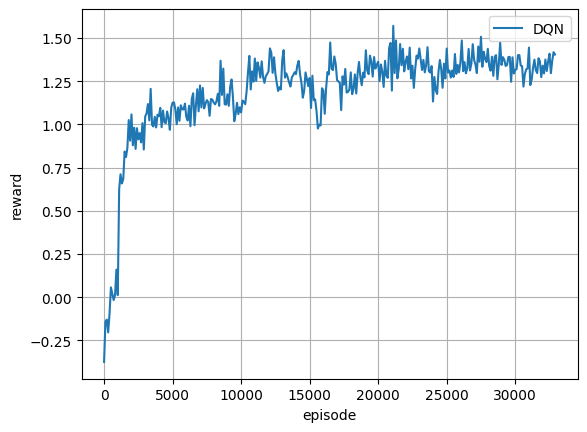

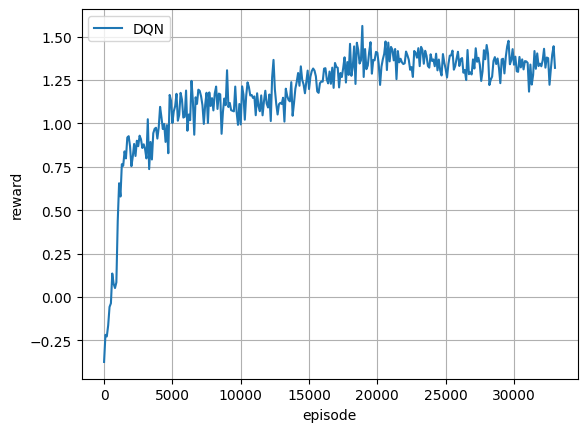

In [8]:
for hyperparams in MLPHyperparamsGrid().to_hyperparams():
    run(hyperparams, num_steps=50000, seed=0, evaluate_every=100, agent='dqn')